# Full transcriptome analysis of [*Rangaraju et al.*](http://www.ncbi.nlm.nih.gov/pubmed/26623667)

Tong Shu Li

In this notebook we analyze the full transcriptome RNA-seq of the worms from PMID:26623667.

None of the genes in this full dataset are exactly zero. Instead, they are all extremely small, meaning that no filtering was done to remove the extremely lowly expressed genes.

In [1]:
import math
import pandas as pd
import seaborn as sns
import sys

In [2]:
sys.path.append("../..")

In [3]:
from src.plots import plot_multi_density
from src.plots import plot_drift
from src.plots import plot_p_val_heatmap

from src.stats import calc_percentile

In [4]:
%matplotlib inline

---

## Read the full transcriptome expression values

In [5]:
full = pd.read_csv("../../data/PMID26623667/mean_cpm_values.tsv", sep = '\t')

In [6]:
full.shape

(230028, 12)

In [7]:
full.head()

,wormbaseid,symbol,seqname,cpm_val,sample,day_add_drug,day_harvest_rna,drug_conc_uM,drug_given,log_cpm,ref_log_cpm,drift
0,WBGene00022521,ZC132.2,ZC132.2,0.000226,1,1,1,0,water,-8.393649,-8.393649,0.0
1,WBGene00019835,R02F2.6,R02F2.6,0.000228,1,1,1,0,water,-8.386604,-8.386604,0.0
2,WBGene00006011,srx-120,F49C5.2,0.000262,1,1,1,0,water,-8.247548,-8.247548,0.0
3,WBGene00022884,ZK1248.17,ZK1248.17,0.000275,1,1,1,0,water,-8.199831,-8.199831,0.0
4,WBGene00005435,srh-227,C35D6.2,0.000298,1,1,1,0,water,-8.116741,-8.116741,0.0


---

## CPM distribution of all samples

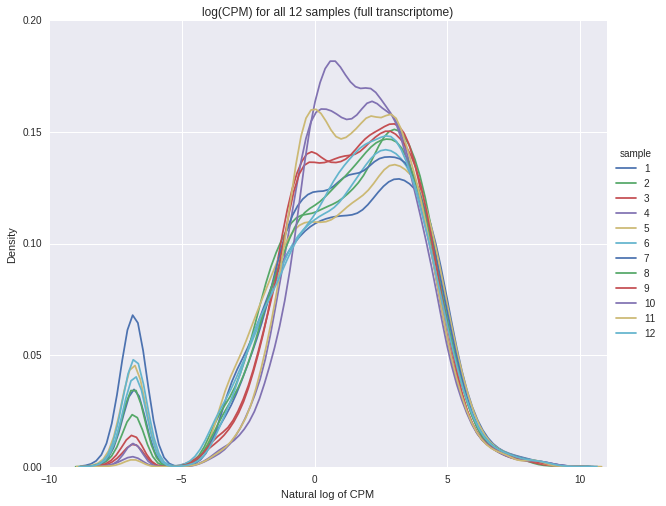

In [8]:
ax = plot_multi_density(
    full, "sample", "log_cpm", rc = {"figure.figsize": (10, 8)}
)
ax.set_xlim((-10, 11))
ax.set_xlabel("Natural log of CPM")
ax.set_title("log(CPM) for all 12 samples (full transcriptome)");

Looks like there is a portion of the genome which had extremely small values of expression (the small hump on the left). These genes should probably be treated as having zero expression because their expression values are so small that the noise to signal ratio is probably very high. We need to be careful of how we interpret these barely expressed genes.

## Examine drift distributions

The drift of all samples with respect to sample 1 has already been pre-calculated during the data cleaning stage. Here we examine the distributions of drift.

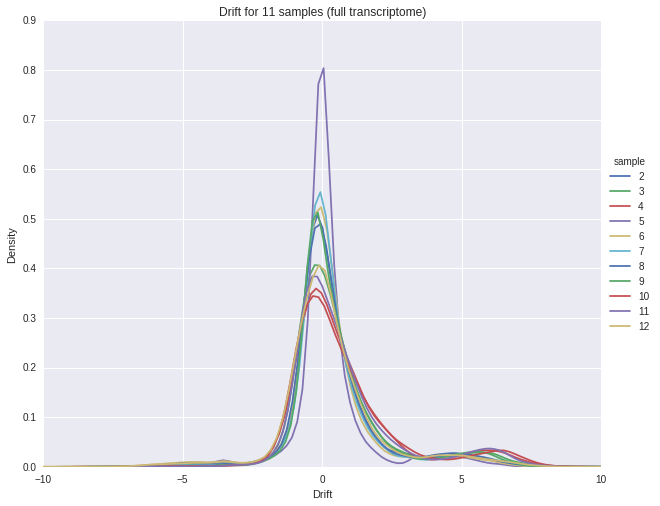

In [9]:
ax = plot_multi_density(
    full.query("sample != 1"), "sample", "drift",
    rc = {"figure.figsize": (10, 8)}
)
ax.set_xlim((-10, 10))
ax.set_title("Drift for 11 samples (full transcriptome)")
ax.set_xlabel("Drift");

Notice that most of the genes do not drift (cluster around 0), while some drift extremely large amounts (absolute value of drift is large). We will see later on that this extreme drift tends to be driven by lowly expressed genes.

Sample 5 (+mianserin, day 3 harvest) seems to be drifting much less than all the other samples. This is a good sign, since this is the youngest worm which received the lifespan extending drug.

When we replot the drift distributions without sample 5, the tallest spike disappears:

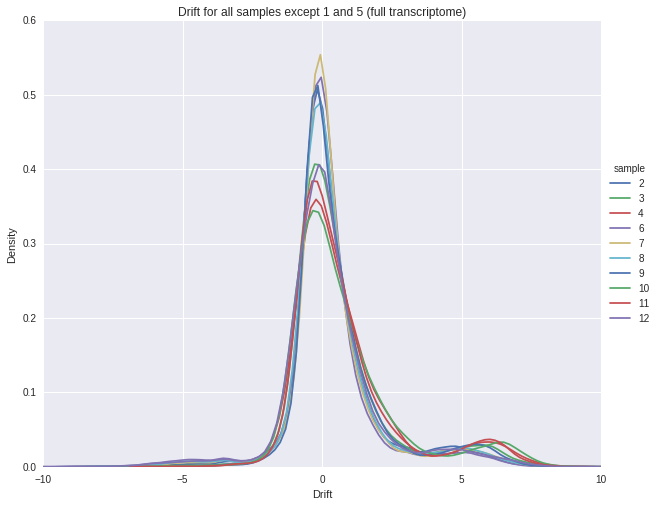

In [10]:
ax = plot_multi_density(
    full.query("sample not in(1, 5)"), "sample", "drift",
    rc = {"figure.figsize": (10, 8)}
)
ax.set_xlim((-10, 10))
ax.set_xlabel("Drift")
ax.set_title("Drift for all samples except 1 and 5 (full transcriptome)");

---

## Drift as a function of expression

Since drift is defined as the log of the relative gene expression at two time points, the amount of original gene expression plays a large role in determining the magnitude of the drift. For example, a gene with a young CPM of 10000 will need to increase its expression to 20000 in order to drift 2x. However, a gene with a young CPM of 0.00001 will only need to increase expression to 0.00002 to achieve the same value of drift.

Since we can be more confident in large absolute changes in expression (easier to measure), we will need to control the drift statistic based on original expression.

### Method

1. Calculate the expression percentile for each gene
2. Group genes into deciles
3. Examine the drift distribution for each decile

In [11]:
ref = full.query("sample == 1")[["wormbaseid", "log_cpm"]]

ref["exp_percentile"] = calc_percentile(ref["log_cpm"])

ref["decile"] = ref["exp_percentile"].map(
    lambda v: math.floor(v) // 10
)

ref = ref.drop("log_cpm", axis = 1)

In [12]:
full = pd.merge(full, ref, how = "left", on = "wormbaseid")

## Do genes at different original expression levels drift equally up and down?

### Water treated worms

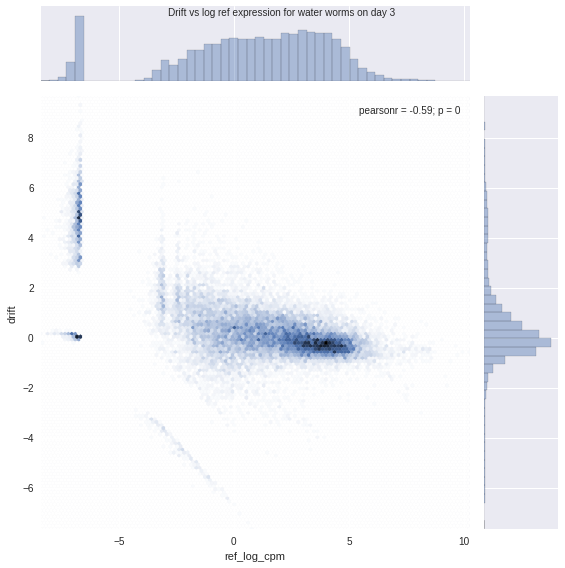

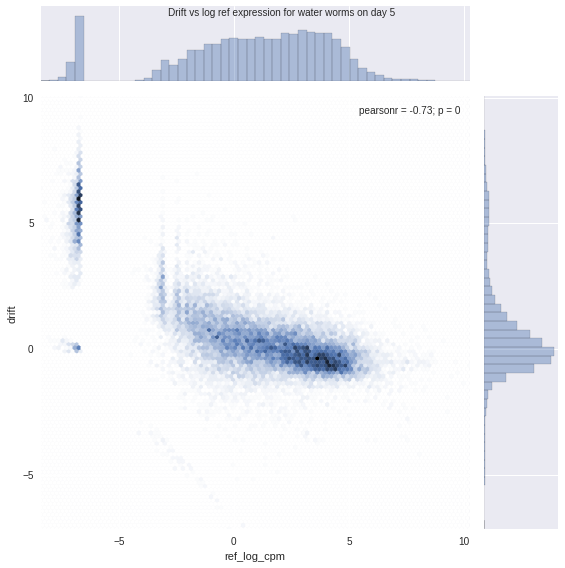

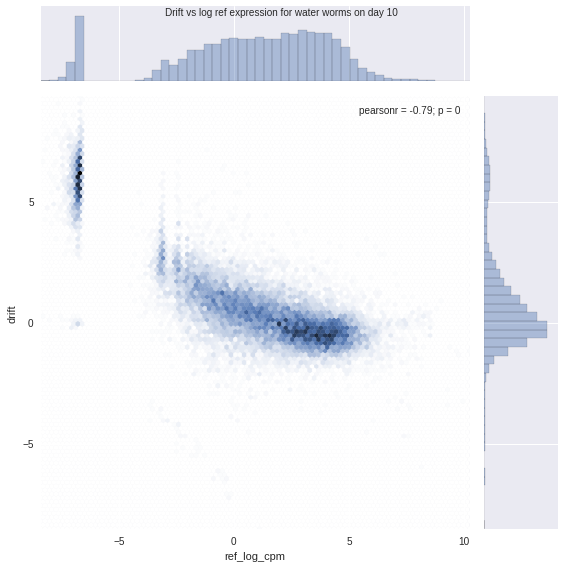

In [13]:
for key, df in full.query("drug_given == 'water' & sample > 1").groupby("day_harvest_rna"):
    ax = sns.jointplot(
        data = df,
        x = "ref_log_cpm",
        y = "drift",
        kind = "hex",
        size = 8
    )
    
    ax.fig.suptitle("Drift vs log ref expression for water worms on day {}".format(key))

Same but using percentile instead:

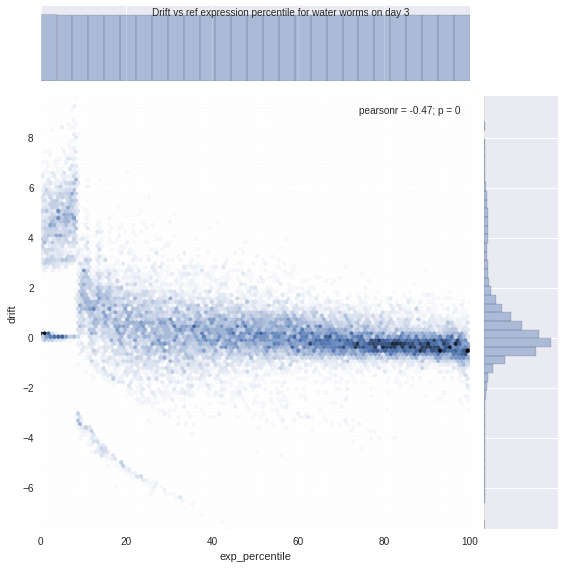

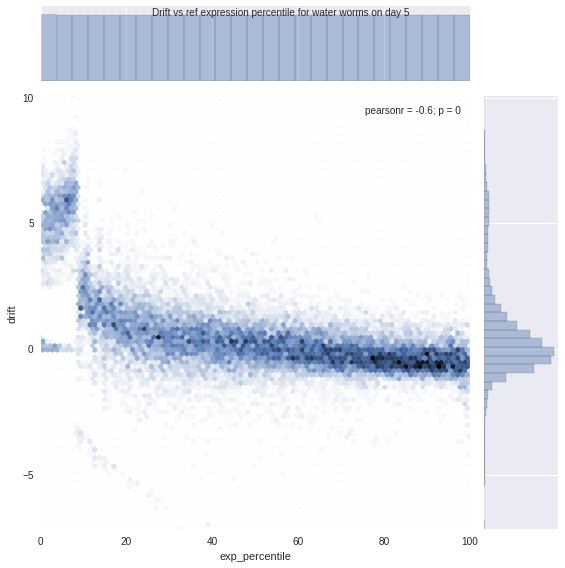

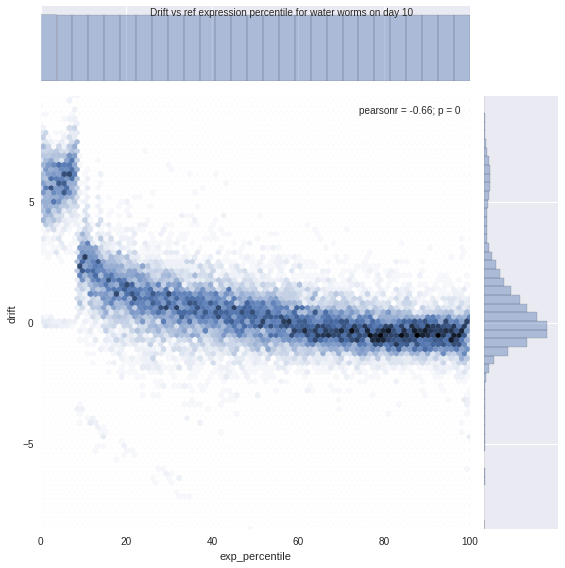

In [14]:
for key, df in full.query("drug_given == 'water' & sample > 1").groupby("day_harvest_rna"):
    ax = sns.jointplot(
        data = df,
        x = "exp_percentile",
        y = "drift",
        kind = "hex",
        size = 8
    )
    
    ax.fig.suptitle("Drift vs ref expression percentile for water worms on day {}".format(key))

### Mianserin treated worms

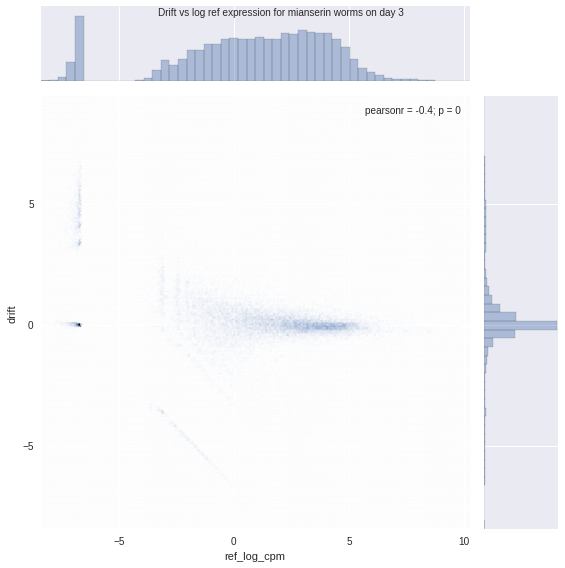

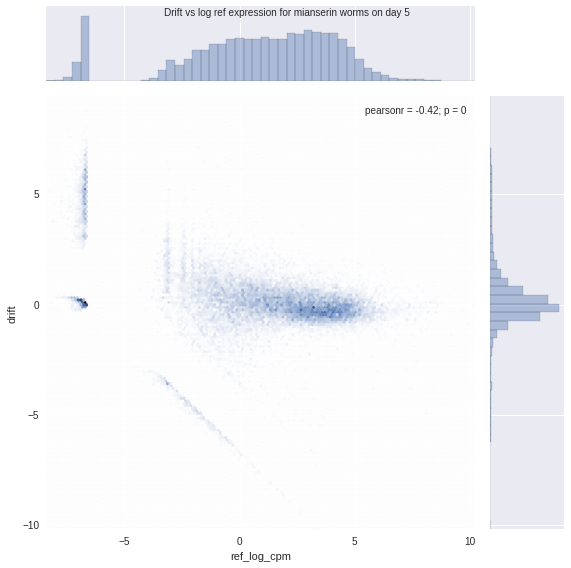

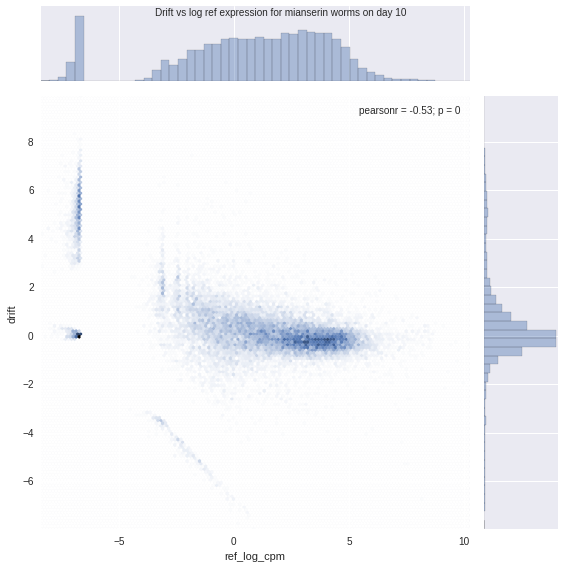

In [15]:
for key, df in full.query("drug_given == 'mianserin' & sample <= 7").groupby("day_harvest_rna"):
    ax = sns.jointplot(
        data = df,
        x = "ref_log_cpm",
        y = "drift",
        kind = "hex",
        size = 8
    )
    
    ax.fig.suptitle("Drift vs log ref expression for mianserin worms on day {}".format(key))

Again with the percentile:

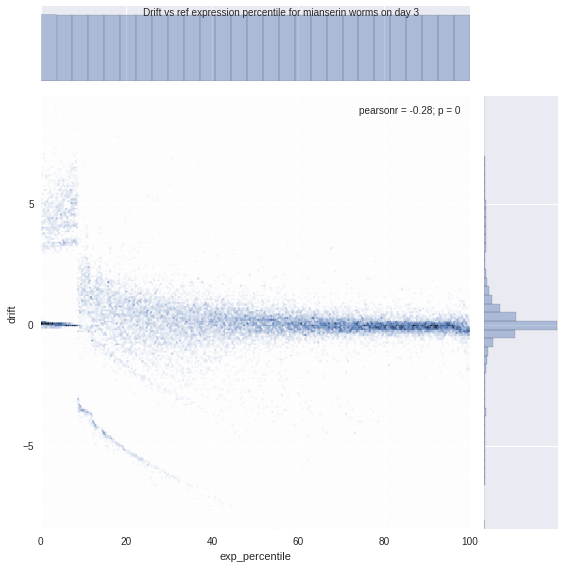

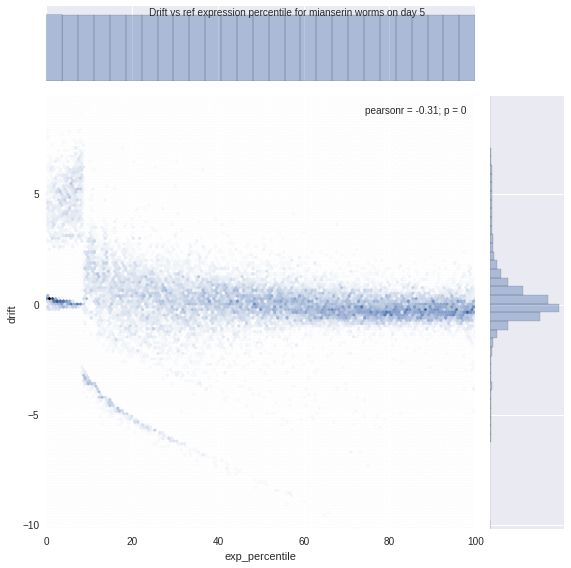

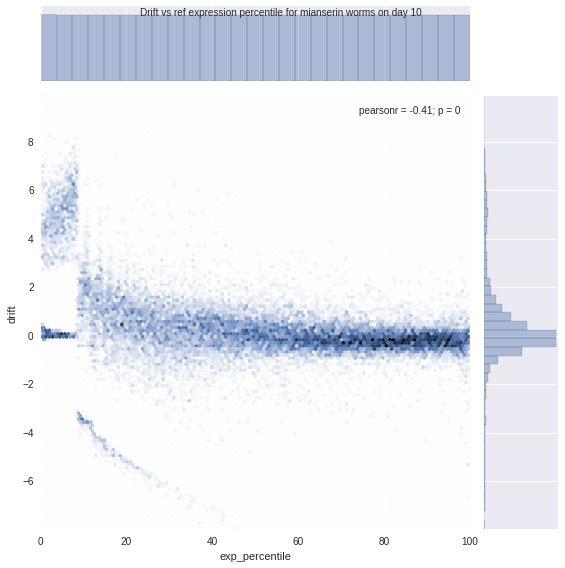

In [16]:
for key, df in full.query("drug_given == 'mianserin' & sample <= 7").groupby("day_harvest_rna"):
    ax = sns.jointplot(
        data = df,
        x = "exp_percentile",
        y = "drift",
        kind = "hex",
        size = 8
    )
    
    ax.fig.suptitle("Drift vs ref expression percentile for mianserin worms on day {}".format(key))

These plots confirm our suspicions that the genes with really low original expression values are more likely to have large drift values. We see that as the expression value of the gene increases, the variance seems to drop (cluster more tightly around zero) and the mean drift decreases.

These data require the filtering which was done for the filtered data. The really low expression values should just be considered as zero and removed completely, since using them for drift calculations will result in greatly different results.

---

## Drift variance as a function of original expression

For each decile of expressed genes, what is the drift variance?

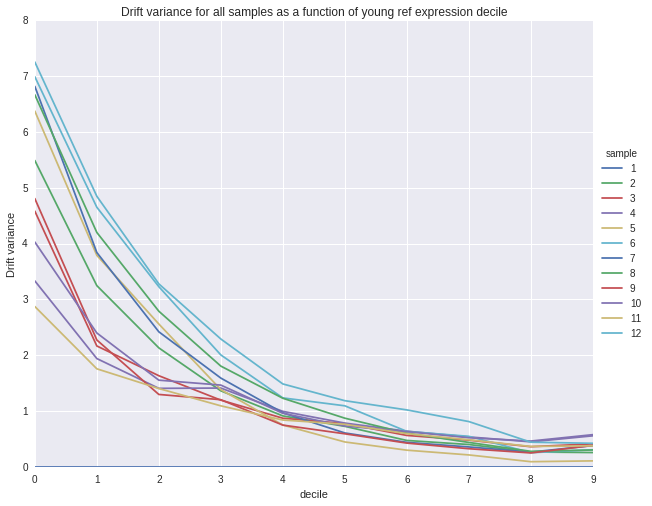

In [17]:
res = pd.DataFrame(
    [
        (sample, decile, df["drift"].var())
        for (sample, decile), df in full.groupby(["sample", "decile"])
    ],
    columns = ["sample", "decile", "drift_var"]
).pivot("decile", "sample", "drift_var")

ax = res.plot(kind = "line", figsize = (10, 8))
ax.set_title("Drift variance for all samples as a function of young ref expression decile")
ax.legend(title = "sample", loc = "center left", bbox_to_anchor = (1, 0.5))
ax.set_ylabel("Drift variance");

Here we see that the lowly expressed genes have drastically increased variance compared to the more highly expressed genes. Therefore including these lowly expressed genes will skew our results, and create more false positive results.

### Water treated worms

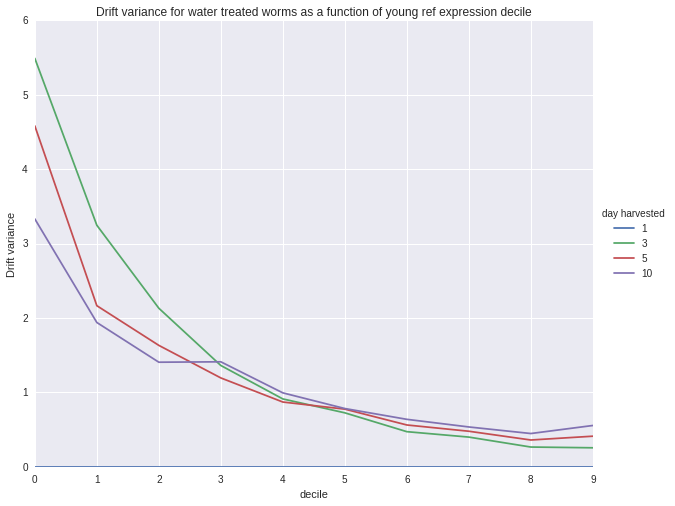

In [18]:
res = pd.DataFrame(
    [
        (day, decile, df["drift"].var())
        for (day, decile), df in (full.query("drug_given == 'water'")
            .groupby(["day_harvest_rna", "decile"]))
    ],
    columns = ["day", "decile", "drift_var"]
).pivot("decile", "day", "drift_var")

ax = res.plot(kind = "line", figsize = (10, 8))
ax.set_title("Drift variance for water treated worms as a function of young ref expression decile")
ax.legend(title = "day harvested", loc = "center left", bbox_to_anchor = (1, 0.5))
ax.set_ylabel("Drift variance");

### Water vs mianserin treated worms

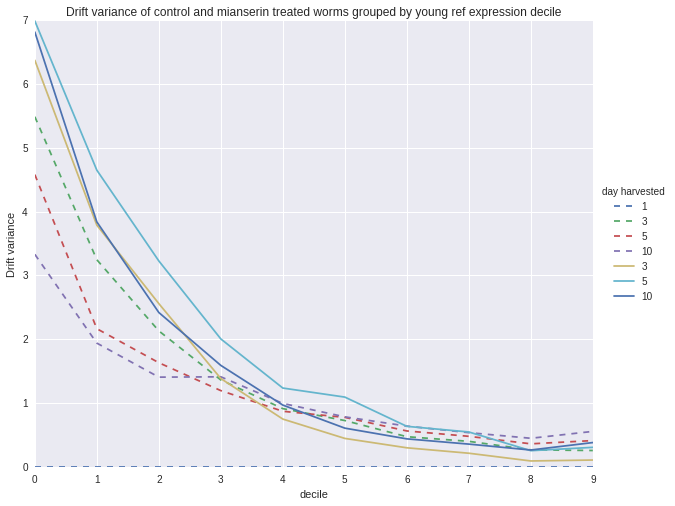

In [19]:
res = pd.DataFrame(
    [
        (day, decile, df["drift"].var())
        for (day, decile), df in (full.query("drug_given == 'water'")
                                  .groupby(["day_harvest_rna", "decile"]))
    ],
    columns = ["day", "decile", "drift_var"]
).pivot("decile", "day", "drift_var")

ax = res.plot(kind = "line", linestyle = "--", figsize = (10, 8))


res = pd.DataFrame(
    [
        (day, decile, df["drift"].var())
        for (day, decile), df in (full.query("drug_given == 'mianserin' & sample <= 7")
                                  .groupby(["day_harvest_rna", "decile"]))
    ],
    columns = ["day", "decile", "drift_var"]
).pivot("decile", "day", "drift_var")

ax = res.plot(kind = "line", linestyle = '-', ax = ax, figsize = (10, 8))

ax.set_title("Drift variance of control and mianserin treated worms grouped by young ref expression decile")

ax.legend(title = "day harvested", loc = "center left", bbox_to_anchor = (1, 0.5))
ax.set_ylabel("Drift variance");

These results aren't as interesting as the ones we had for the filtered dataset. The lowly expressed genes are really interfering with the interpretation, since the water treated worms (dotted lines) have higher drift variance as we reach the top 50% of expressed genes.

---

## Drift for water treated worms, all genes (full)

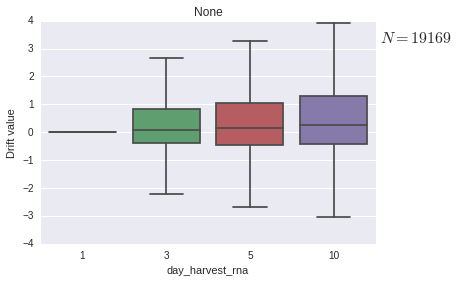

In [20]:
temp = full.query("drug_given == 'water'")

plot_drift(
    "box", temp,
    "day_harvest_rna", "drift", "seqname"
);

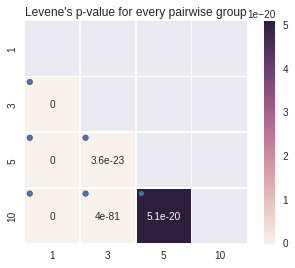

In [21]:
plot_p_val_heatmap(temp, "day_harvest_rna", "drift", circles = True);

## Effect of mianserin on drift (full transcriptome)

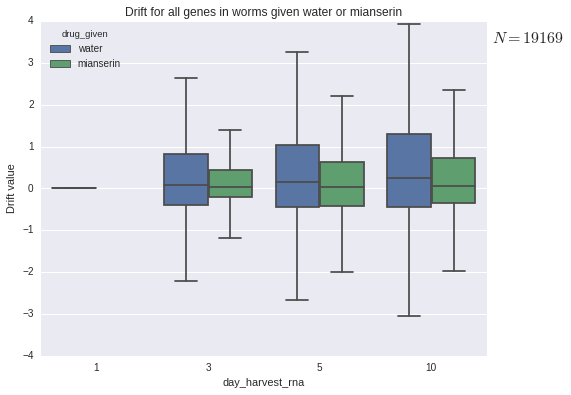

In [22]:
temp = full.query("day_add_drug == 1 & drug_conc_uM in(0, 50)")

plot_drift(
    "box", temp, "day_harvest_rna", "drift", "seqname",
    groupby = "drug_given", rc = {"figure.figsize": (8, 6)},
    title = "Drift for all genes in worms given water or mianserin"
);

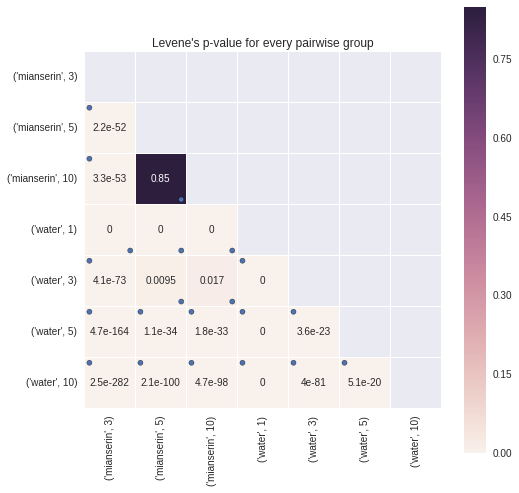

In [23]:
plot_p_val_heatmap(
    temp, ["drug_given", "day_harvest_rna"], "drift",
    rc = {"figure.figsize": (8, 8)}, circles = True
);